## Cálculo dos Pesos 

Nessa primeira parte do notebook, a ideia é fazer uso das funções já trabalhadas no último notebook, como matrix_seriation e calcula_pesos_hrp, para gerar os pesos de cada uma das 10 ações selecionadas para todas as 10 janelas analisadas.

**Problema:** não tô conseguindo tirar os dendogramas (manter os 10 dendogramas fica bem poluído visualmente). O problema é que colunas_seriation usa do dendograma pra seriar as ações

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import turingquant as tq
import yfinance as yf
import seaborn as sns

In [67]:
#Empresas analisadas: 
#Bancos: Itaú, Santander, Banco do Brasil e Bradesco; 
#Energia:Transmissão Paulista, Engie e AES Brasil;
#Saneamento: Sanepa, SABESP e Companhia de Saneamento de Minas Gerais
tickers = ['ITUB4.SA', 'SANB4.SA', 'BBAS3.SA', 'BBDC4.SA',
'TRPL4.SA', 'EGIE3.SA', 'AESB3.SA', 
'SAPR11.SA', 'SBSP3.SA', 'CSMG3.SA']

In [68]:
def matrix_seriation(retornos: pd.DataFrame):
    matriz_cov = retornos.cov()
    dendograma = sns.clustermap(matriz_cov, method='ward', metric='euclidean')
    colunas_seriation = dendograma.dendrogram_col.reordered_ind
    colunas_seriation = retornos.columns[colunas_seriation]
    return (matriz_cov, colunas_seriation)

In [71]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

[*********************100%***********************]  10 of 10 completed
Janela de 01/01/2017 - 01/04/2021
[*********************100%***********************]  10 of 10 completed
Janela de 01/04/2017 - 01/07/2021
[*********************100%***********************]  10 of 10 completed
Janela de 01/07/2017 - 01/10/2021
[*********************100%***********************]  10 of 10 completed
Janela de 01/10/2017 - 01/01/2022
[*********************100%***********************]  10 of 10 completed
Janela de 01/01/2018 - 01/04/2022
[*********************100%***********************]  10 of 10 completed
Janela de 01/04/2018 - 01/07/2022
[*********************100%***********************]  10 of 10 completed
Janela de 01/07/2018 - 01/10/2022
[*********************100%***********************]  10 of 10 completed
Janela de 01/10/2018 - 01/01/2023
[*********************100%***********************]  10 of 10 completed
Janela de 01/01/2019 - 01/04/2023
[*********************100%***********************]  10 

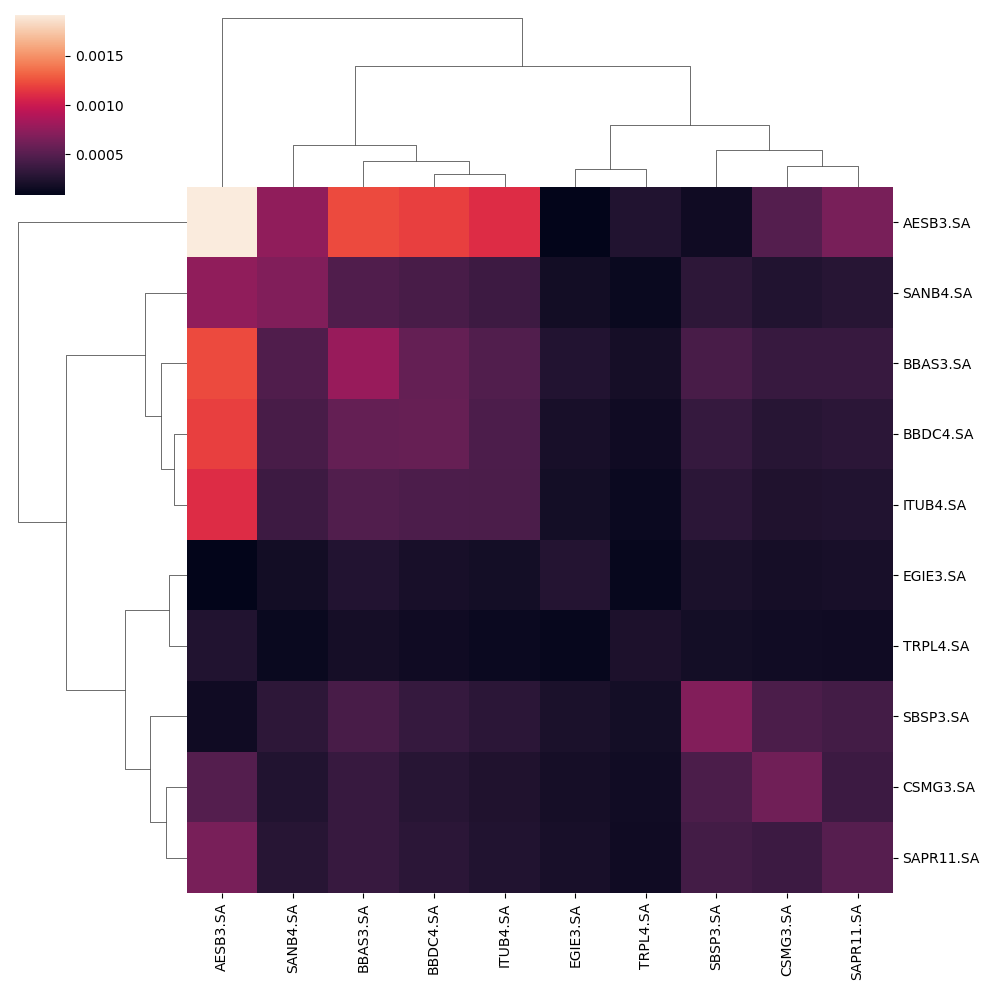

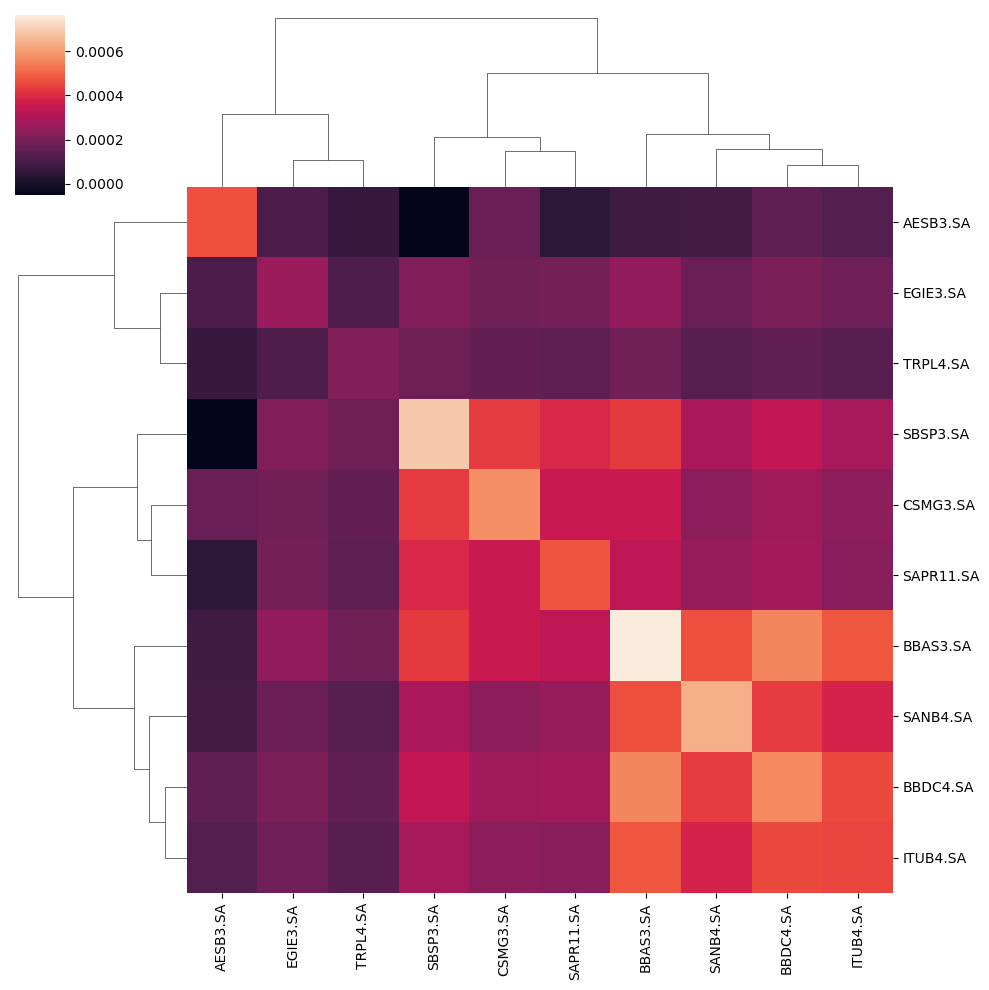

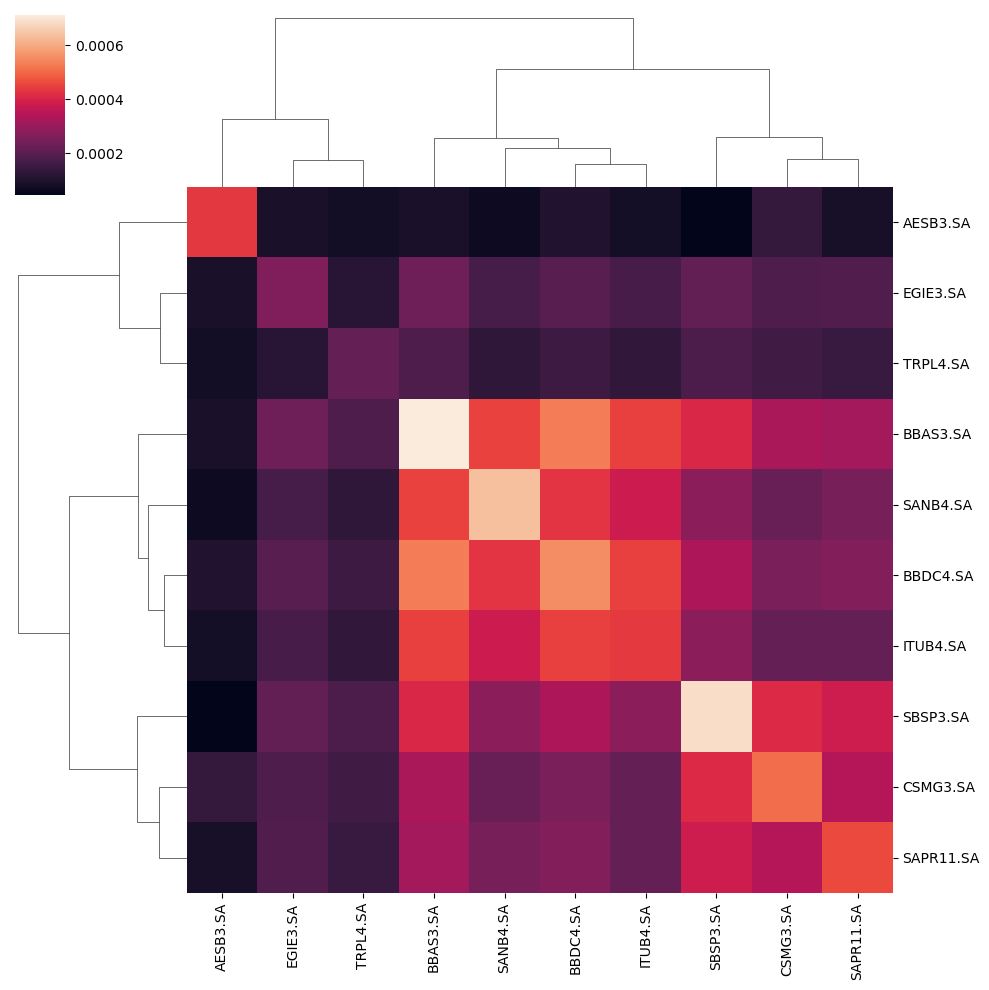

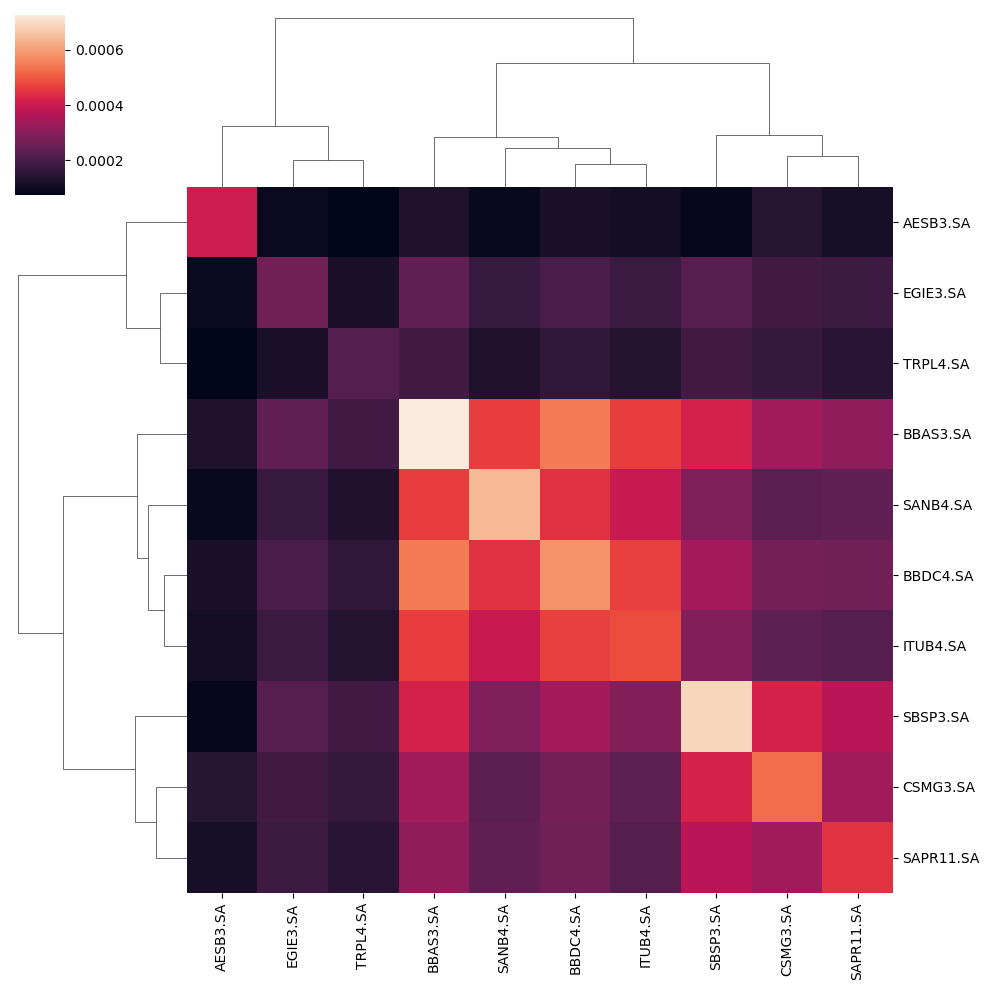

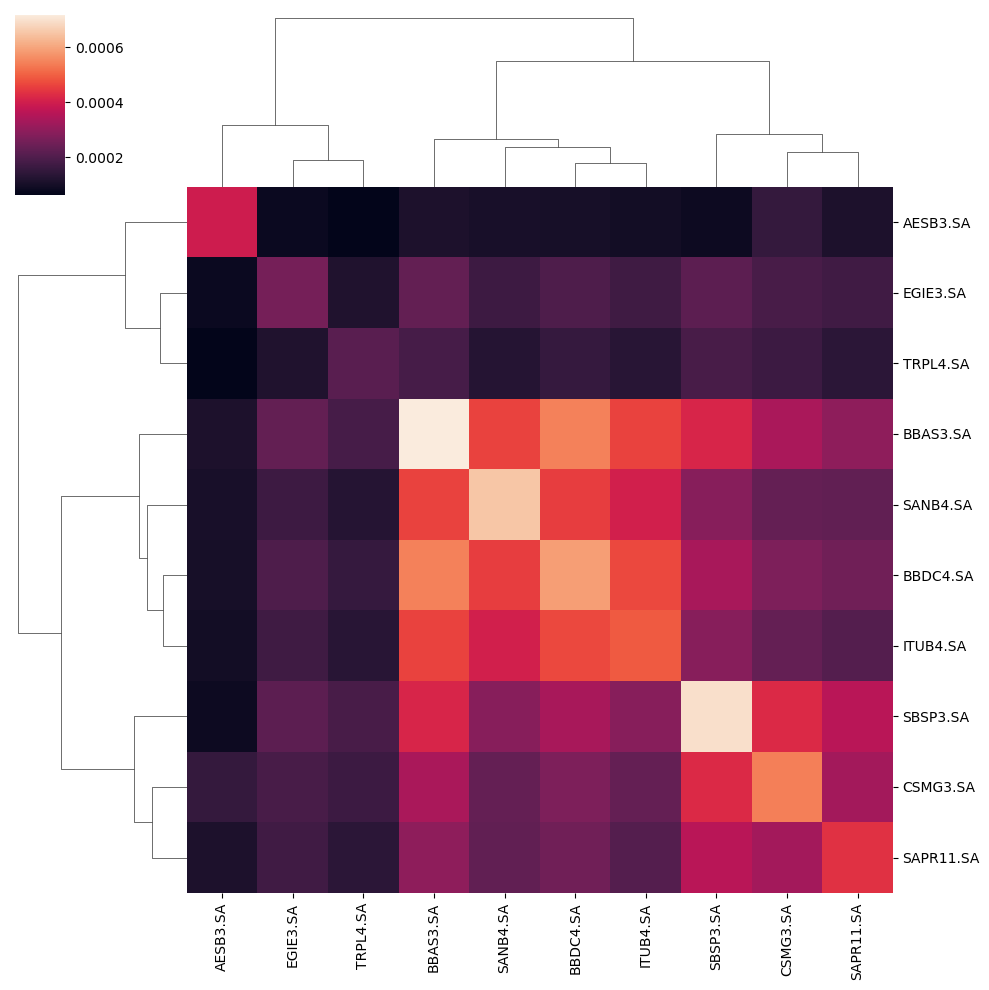

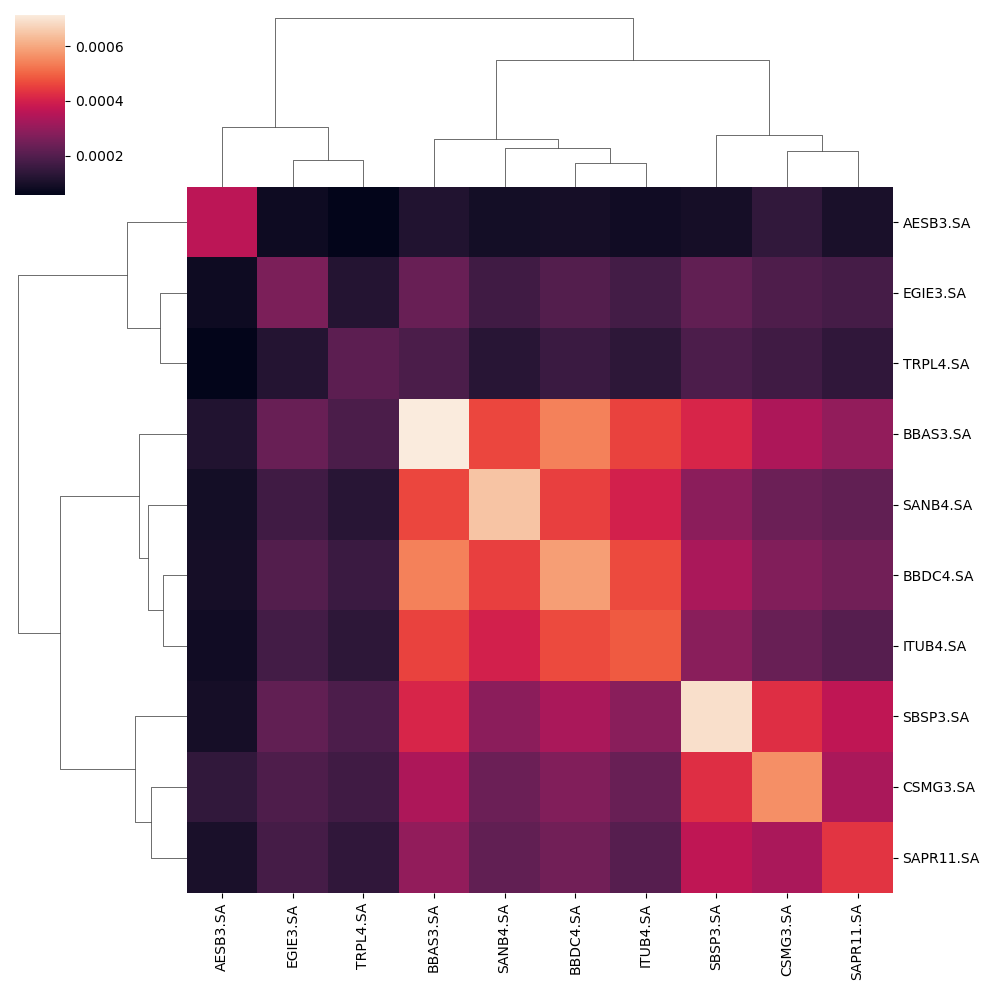

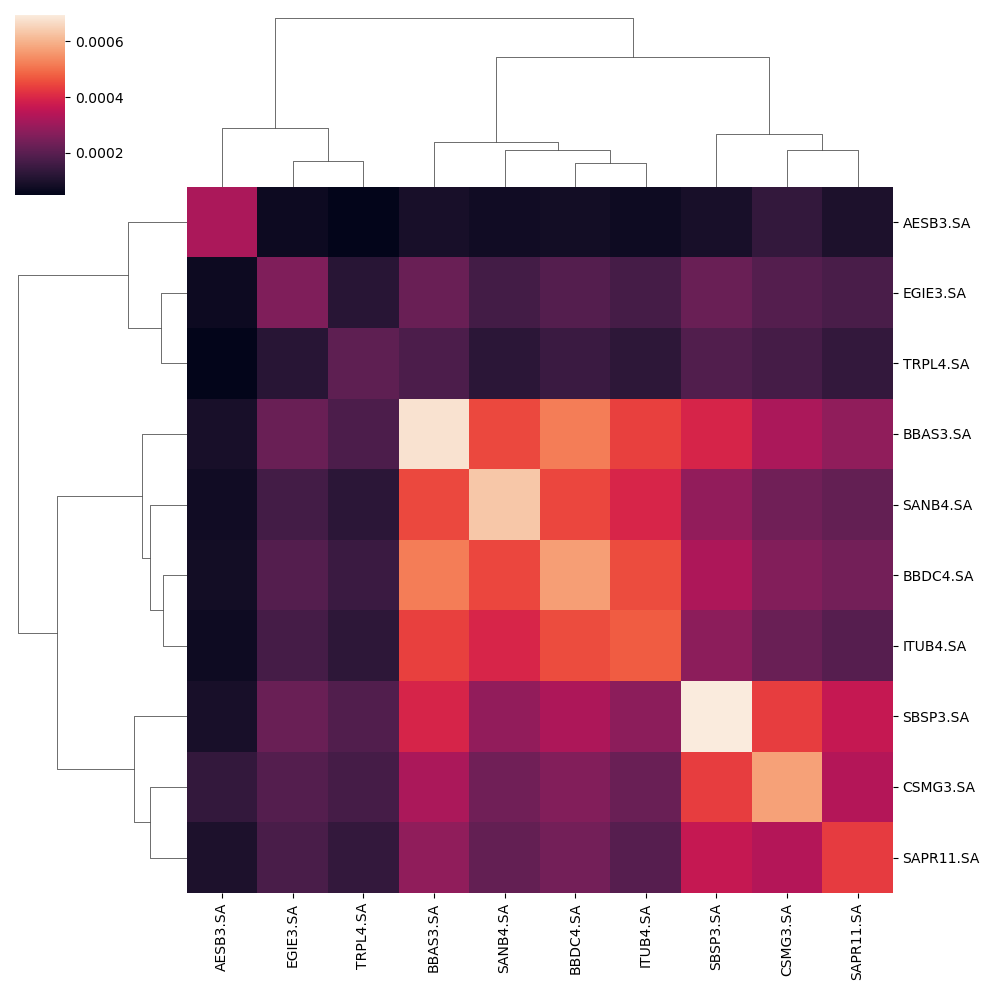

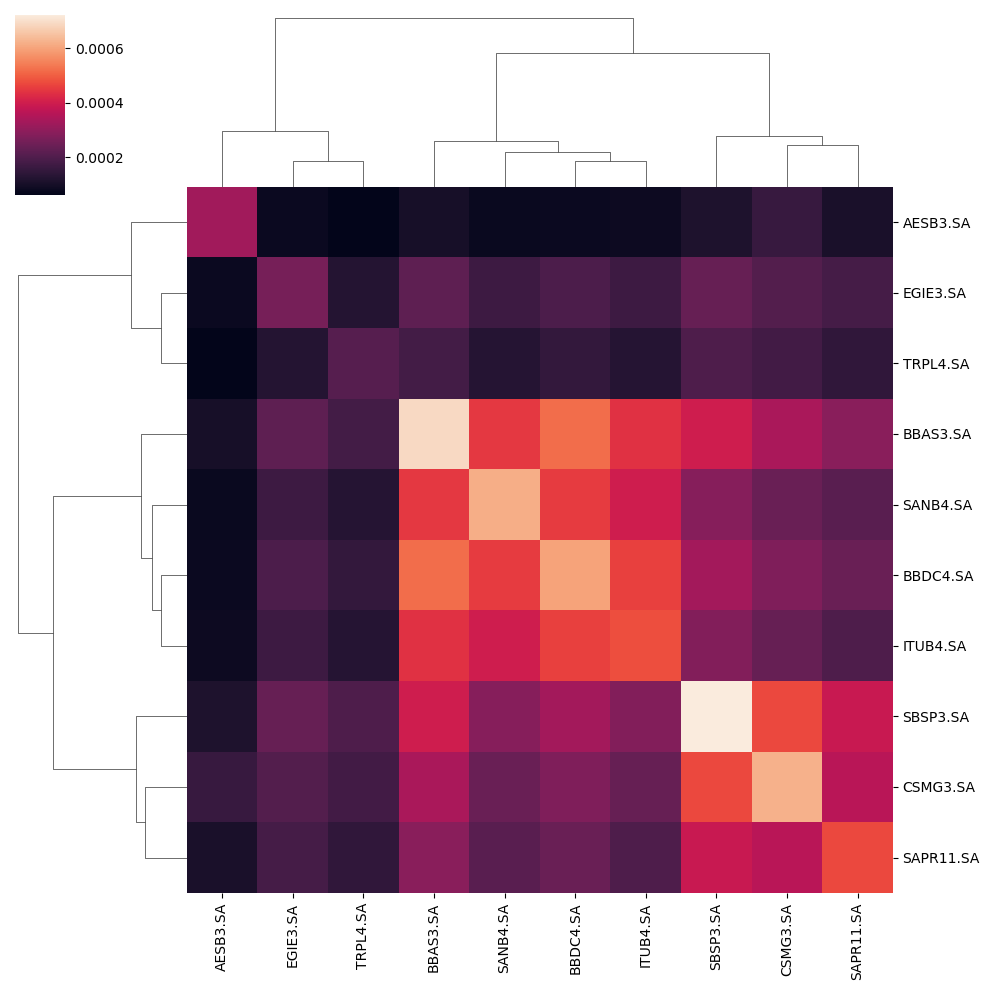

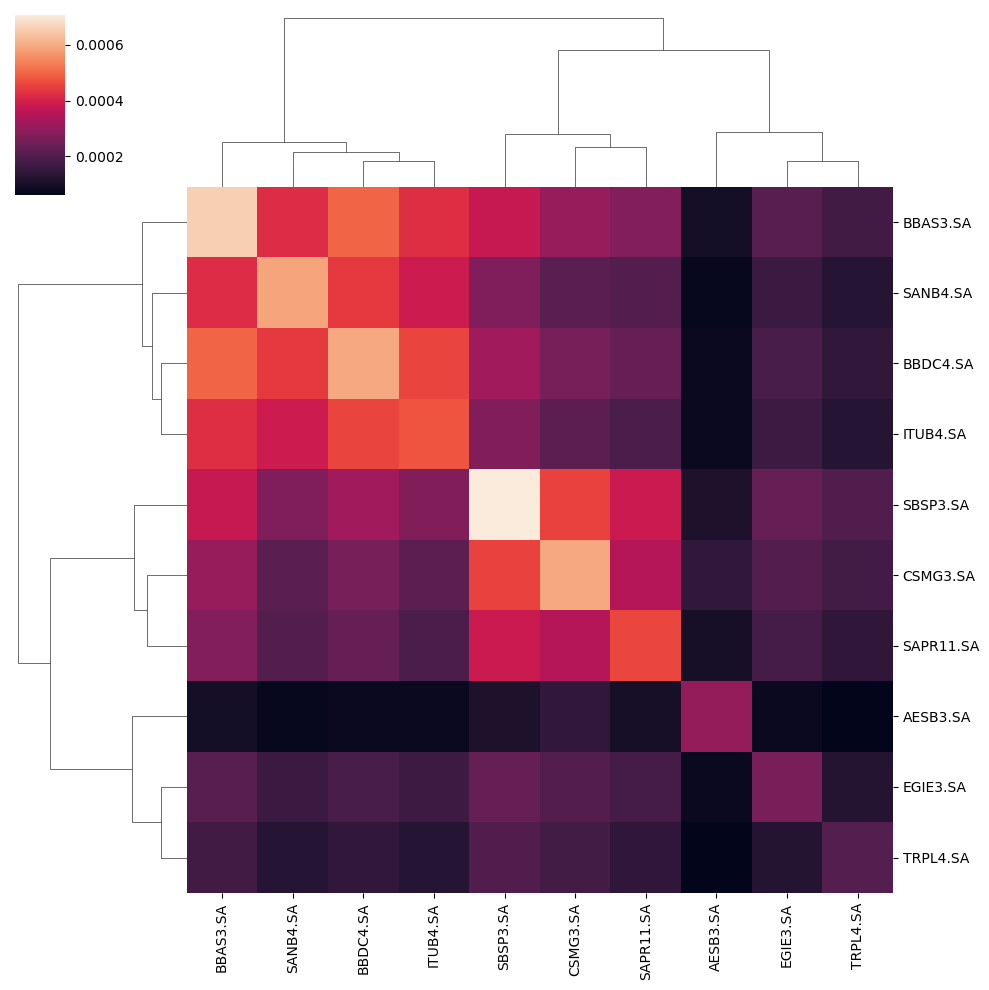

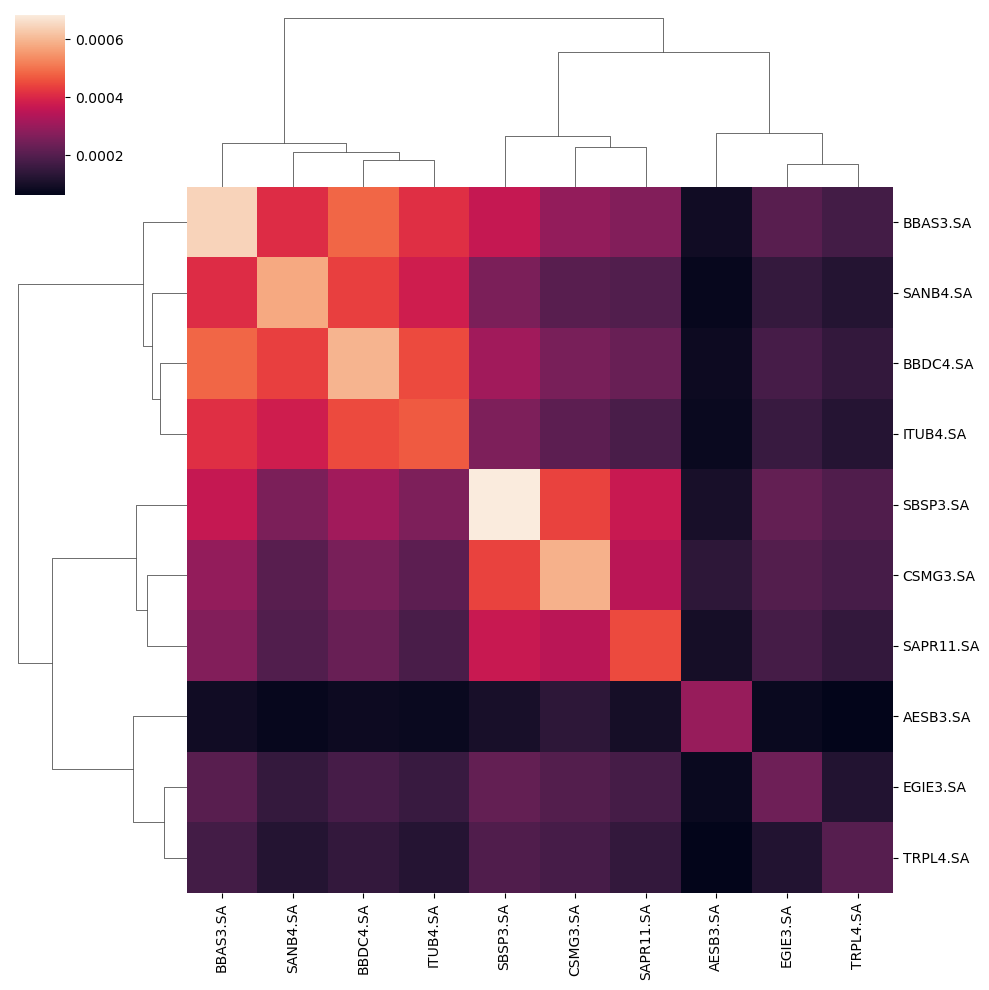

In [75]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Datas de início e fim gerais
data_inicio_total = datetime(2017, 1, 1)
data_fim_total = datetime(2023, 7, 1)

# Datas de início e fim da primeira janela
data_inicio_janela = datetime(2017, 1, 1)
data_fim_janela = datetime(2021, 4, 1)

lista_pesos = []

# Loop para percorrer as janelas de dados
while data_fim_janela <= data_fim_total:
    df_close = yf.download(tickers, start=data_inicio_janela, end=data_fim_janela)['Adj Close']
    print(f"Janela de {data_inicio_janela.strftime('%d/%m/%Y')} - {data_fim_janela.strftime('%d/%m/%Y')}")
    retornos = tq.metrics.returns(df_close)
    matriz_cov,colunas_seriation = matrix_seriation(retornos)
    pesos = calcula_pesos_hrp(matriz_cov, colunas_seriation) * 100
    lista_pesos.append(pesos)
    data_inicio_janela += relativedelta(months=3)
    data_fim_janela += relativedelta(months=3)

In [76]:
lista_pesos

[AESB3.SA      2.865955
 SANB4.SA      8.037460
 BBAS3.SA      6.456202
 BBDC4.SA      4.704427
 ITUB4.SA      5.963337
 EGIE3.SA     23.796120
 TRPL4.SA     28.224072
 SBSP3.SA      7.978192
 CSMG3.SA      5.342172
 SAPR11.SA     6.632064
 dtype: float64,
 AESB3.SA     13.149283
 EGIE3.SA     23.422747
 TRPL4.SA     23.037823
 SBSP3.SA      4.368969
 CSMG3.SA      5.232732
 SAPR11.SA     9.618004
 BBAS3.SA      5.935415
 SANB4.SA      6.496902
 BBDC4.SA      3.864576
 ITUB4.SA      4.873551
 dtype: float64,
 AESB3.SA     13.472790
 EGIE3.SA     22.359152
 TRPL4.SA     21.954188
 BBAS3.SA      4.061453
 SANB4.SA      4.546595
 BBDC4.SA      7.085658
 ITUB4.SA      8.947622
 SBSP3.SA      6.574542
 CSMG3.SA      5.222375
 SAPR11.SA     5.775626
 dtype: float64,
 AESB3.SA     14.285923
 EGIE3.SA     22.021215
 TRPL4.SA     22.045971
 BBAS3.SA      3.951140
 SANB4.SA      4.480900
 BBDC4.SA      6.965594
 ITUB4.SA      8.346779
 SBSP3.SA      6.657979
 CSMG3.SA      5.161824
 SAPR11.SA   